# CNN + Masks (UNET)

This notebook uses the model from 
https://ieeexplore.ieee.org/abstract/document/9057809

In addition we add segmentation masks from unet to a 4. channel of the images.
The input is therefore R - G - B - Cutout (grayscale img).

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from generators import MaskPredDataGenerator

In [2]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
train_path = 'data/chest-x-ray/train/'
test_path = 'data/chest-x-ray/test/'
val_path = 'data/chest-x-ray/val/'

train_mask_path = 'data/chest-x-ray/masks/train/'
val_mask_path = 'data/chest-x-ray/masks/val/'
test_mask_path = 'data/chest-x-ray/masks/test/'

In [3]:
np.random.seed(200)
tf.random.set_seed(200)

## 1 Data preparation

In [4]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask'])  
    # IMGs
    for label_folder in os.listdir(img_folder):
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]
            mask_path = str(masks_folder)+str(label_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'

            if img_path is not None:
                tmp_df = tmp_df.append({'img': img_path, 'label': label_folder, 'mask': mask_path}, ignore_index=True)

    return tmp_df

In [5]:
def load_testimages_from_folder(img_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label'])
    # IMGs
    for label_folder in os.listdir(img_folder):
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]
            if img_path is not None:
                tmp_df = tmp_df.append({'img': img_path, 'label': label_folder}, ignore_index=True)
    return tmp_df

In [6]:
df_train = load_images_from_folder(train_path, train_mask_path)
df_val = load_images_from_folder(val_path, val_mask_path)
df_test = load_images_from_folder(test_path, test_mask_path)

In [7]:
pd.set_option('display.max_colwidth', -1)
df_test

,img,label,mask
0,data/chest-x-ray/test/NORMAL/IM-0001-0001.jpeg,NORMAL,data/chest-x-ray/masks/test/NORMAL/IM-0001-0001_predmask.jpg
1,data/chest-x-ray/test/NORMAL/IM-0003-0001.jpeg,NORMAL,data/chest-x-ray/masks/test/NORMAL/IM-0003-0001_predmask.jpg
2,data/chest-x-ray/test/NORMAL/IM-0005-0001.jpeg,NORMAL,data/chest-x-ray/masks/test/NORMAL/IM-0005-0001_predmask.jpg
3,data/chest-x-ray/test/NORMAL/IM-0006-0001.jpeg,NORMAL,data/chest-x-ray/masks/test/NORMAL/IM-0006-0001_predmask.jpg
4,data/chest-x-ray/test/NORMAL/IM-0007-0001.jpeg,NORMAL,data/chest-x-ray/masks/test/NORMAL/IM-0007-0001_predmask.jpg
...,...,...,...
519,data/chest-x-ray/test/PNEUMONIA/person96_bacteria_465.jpeg,PNEUMONIA,data/chest-x-ray/masks/test/PNEUMONIA/person96_bacteria_465_predmask.jpg
520,data/chest-x-ray/test/PNEUMONIA/person96_bacteria_466.jpeg,PNEUMONIA,data/chest-x-ray/masks/test/PNEUMONIA/person96_bacteria_466_predmask.jpg
521,data/chest-x-ray/test/PNEUMONIA/person97_bacteria_468.jpeg,PNEUMONIA,data/chest-x-ray/masks/test/PNEUMONIA/person97_bacteria_468_predmask.jpg
522,data/chest-x-ray/test/PNEUMONIA/person99_bacteria_473.jpeg,PNEUMONIA,data/chest-x-ray/masks/test/PNEUMONIA/person99_bacteria_473_predmask.jpg


In [8]:
# df_all = pd.DataFrame()
# df_all = df_all.append(df_train, ignore_index=True)
# df_all = df_all.append(df_val, ignore_index=True)
# df_all = df_all.append(df_test, ignore_index=True)
# df_all.reset_index(inplace=True)

In [9]:
# df_all

In [10]:
# Shuffle
# df_all = df_all.sample(frac=1).reset_index(drop=True)
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=200).reset_index(drop=True)
df_val = df_val.sample(frac=1, random_state=200).reset_index(drop=True)

In [11]:
# from sklearn.model_selection import train_test_split
# df_train, df_val_test = train_test_split(df_all, test_size=0.2, stratify=df_all['label']) 
# df_test, df_val = train_test_split(df_val_test, test_size=0.5, stratify=df_val_test['label']) 

In [12]:
# df_train.reset_index(inplace=True)
# df_val.reset_index(inplace=True)
# df_test.reset_index(inplace=True)

In [13]:
print('=== Data: ===')
print('Train:', len(df_train))
print('Val:', len(df_val))
print('Test:', len(df_test))

=== Data: ===
Train: 5216
Val: 116
Test: 524


In [14]:
df_train['label'].replace(
    to_replace='NORMAL',
    value=0,
    inplace=True
)
df_train['label'].replace(
    to_replace='PNEUMONIA',
    value=1,
    inplace=True
)
df_val['label'].replace(
    to_replace='NORMAL',
    value=0,
    inplace=True
)
df_val['label'].replace(
    to_replace='PNEUMONIA',
    value=1,
    inplace=True
)
df_test['label'].replace(
    to_replace='NORMAL',
    value=0,
    inplace=True
)
df_test['label'].replace(
    to_replace='PNEUMONIA',
    value=1,
    inplace=True
)

In [15]:
df_train.head()

,img,label,mask
0,data/chest-x-ray/train/PNEUMONIA/person307_bacteria_1441.jpeg,1,data/chest-x-ray/masks/train/PNEUMONIA/person307_bacteria_1441_predmask.jpg
1,data/chest-x-ray/train/PNEUMONIA/person1400_bacteria_3554.jpeg,1,data/chest-x-ray/masks/train/PNEUMONIA/person1400_bacteria_3554_predmask.jpg
2,data/chest-x-ray/train/PNEUMONIA/person1369_virus_2355.jpeg,1,data/chest-x-ray/masks/train/PNEUMONIA/person1369_virus_2355_predmask.jpg
3,data/chest-x-ray/train/PNEUMONIA/person488_virus_992.jpeg,1,data/chest-x-ray/masks/train/PNEUMONIA/person488_virus_992_predmask.jpg
4,data/chest-x-ray/train/NORMAL/IM-0482-0001.jpeg,0,data/chest-x-ray/masks/train/NORMAL/IM-0482-0001_predmask.jpg



## 2 Data generator

In [16]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq_img = iaa.Sequential([
    sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}
    )),
    sometimes(iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25)),
], random_order=True)

class TrainDataGenerator4Channels(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        X_imgs = []
        X_masks = []
        Y = self.df['label'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]])), (self.img_size, self.img_size))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]

            cutout_img = img[:,:,2] * mask # multiply with the mask which is binarized, so only the lung will remain, everything else will be set to 0
            cutout_img = cutout_img.reshape(256,256,1)

            # augment
            if(self.augment is True):
                seq_img_i = seq_img.to_deterministic()
                aug_img = seq_img_i.augment_image(img)
                aug_mask = seq_img_i.augment_image(cutout_img)

                fourChannelImg = np.dstack([aug_img, aug_mask])
            else:
                fourChannelImg = np.dstack([img, cutout_img])

            # normalize
            fourChannelImg = fourChannelImg / 255.0

            X_imgs.append(fourChannelImg)

        return X_imgs, Y

In [17]:
train_generator = TrainDataGenerator4Channels(df_train, True, IMG_SIZE, batch_size=32, shuffle=True)
val_generator = TrainDataGenerator4Channels(df_val, False, IMG_SIZE, batch_size=32, shuffle=True)

In [18]:
a = train_generator.__getitem__(1)[0][0]

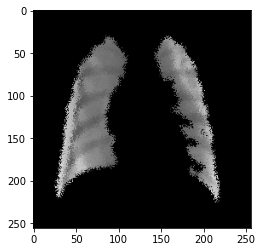

In [19]:
plt.imshow(a[:,:,3], cmap='gray')

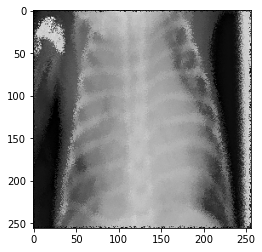

In [20]:
plt.imshow(a[:,:,0], cmap='gray')

## 3 Model training

In [32]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,4)))
model.add(Activation(activations.relu))
model.add(Conv2D(32, (3,3), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,4)))
model.add(Activation(activations.relu))
model.add(Conv2D(128, (2,2), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      1184      
_________________________________________________________________
activation_6 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)       

In [33]:
weight_for_0 = (1 / len(df_train.loc[df_train['label'] == 0]))*(len(df_train))/2.0 
weight_for_1 = (1 / len(df_train.loc[df_train['label'] == 1]))*(len(df_train))/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [34]:
mcp_save = ModelCheckpoint('models/custom_3008.h5', save_best_only=True, monitor='val_loss', mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 0, verbose=1,factor=0.3, min_lr=0.000001)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')

In [35]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    class_weight=class_weight,
                    callbacks=[mcp_save, learning_rate_reduction],
                    verbose = True)

Epoch 1/10
163/163 [==============================] - 99s 608ms/step - loss: 0.5512 - accuracy: 0.6892 - val_loss: 0.5855 - val_accuracy: 0.6667
Epoch 2/10
163/163 [==============================] - 97s 592ms/step - loss: 0.3595 - accuracy: 0.8376 - val_loss: 0.4401 - val_accuracy: 0.7917
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8623
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
163/163 [==============================] - 94s 579ms/step - loss: 0.3048 - accuracy: 0.8623 - val_loss: 0.4502 - val_accuracy: 0.7708
Epoch 4/10
163/163 [==============================] - 96s 592ms/step - loss: 0.2658 - accuracy: 0.8779 - val_loss: 0.3726 - val_accuracy: 0.8229
Epoch 5/10
163/163 [==============================] - 97s 593ms/step - loss: 0.2402 - accuracy: 0.8944 - val_loss: 0.2921 - val_accuracy: 0.8646
Epoch 6/10
163/163 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9007
Epoch 00006: 

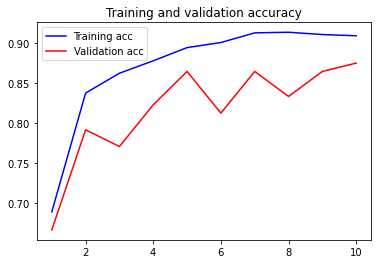

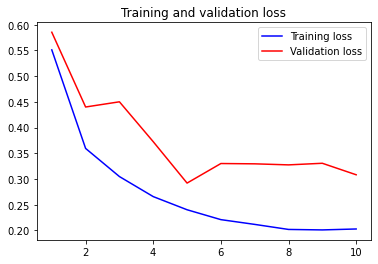

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4 Model evaluation

In [38]:
df_test.head()

,img,label,mask
0,data/chest-x-ray/test/PNEUMONIA/person1_virus_8.jpeg,1,data/chest-x-ray/masks/test/PNEUMONIA/person1_virus_8_predmask.jpg
1,data/chest-x-ray/test/PNEUMONIA/person1622_virus_2810.jpeg,1,data/chest-x-ray/masks/test/PNEUMONIA/person1622_virus_2810_predmask.jpg
2,data/chest-x-ray/test/NORMAL/IM-0030-0001.jpeg,0,data/chest-x-ray/masks/test/NORMAL/IM-0030-0001_predmask.jpg
3,data/chest-x-ray/test/NORMAL/NORMAL2-IM-0289-0001.jpeg,0,data/chest-x-ray/masks/test/NORMAL/NORMAL2-IM-0289-0001_predmask.jpg
4,data/chest-x-ray/test/PNEUMONIA/person1_virus_12.jpeg,1,data/chest-x-ray/masks/test/PNEUMONIA/person1_virus_12_predmask.jpg


In [39]:
test_generator = TrainDataGenerator4Channels(df_val, False, IMG_SIZE, batch_size=32, shuffle=False)

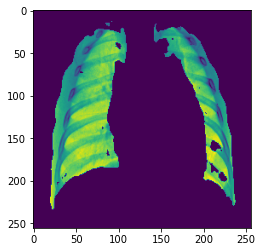

In [40]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,3])

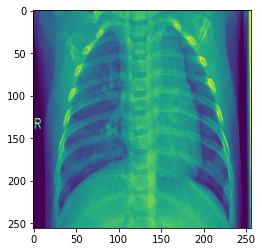

In [41]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,2])

In [42]:
model.evaluate(test_generator)

3/3 [==============================] - 1s 250ms/step - loss: 0.2719 - accuracy: 0.8958


[0.2718776762485504, 0.8958333134651184]

In [43]:
#m = (model.predict(test_generator) > 0.5).astype("int32")